In [3]:
!pip install numpy

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/4b/d7/ecf66c1cd12dc28b4040b15ab4d17b773b87fa9d29ca16125de01adb36cd/numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.0 MB/s eta 0:00:0000:0100:01


In [7]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c1/f2/325897d6c498278b0f8b460d44b516f5db865ddb4ba9018e9fe58a3e4633/matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/58/56/e2c43dcfa1f9c7db4d5e3d6f5134b24ed953f4e2133a4b12f0062148db58/contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/a6/ba/5eac3e9c9bbc2dea3606e46de08bcef0908d74e7ccf89a71701b95a16747/fonttools-4.49.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
import numpy as np

file_path = "nike.splat"

def parse_splats(file_path):
    dtype = np.dtype([
        ('position', np.float32, (3,)),
        ('scale', np.float32, (3,)),
        ('color', np.uint8, (4,)),
        ('rotation', np.uint8, (4,))
    ])
    with open(file_path, 'rb') as file:
        splats = np.fromfile(file, dtype=dtype)
    
    positions = []
    colors = []
    scales = []
    rotations = []

    for i, splat in enumerate(splats):
        # Flatten position and scale directly
        positions.extend(splat['position'])
        scales.extend(splat['scale'])

        # Normalize colors to [0, 1] and flatten
        #normalized_colors = (splat['color'] / 255.0).tolist()
        # colors.extend(normalized_colors)
        colors.extend(splat['color'])

        # Decode rotation as (c - 128) / 128.0 and flatten
        decoded_rotation = [(c - 128) / 128.0 for c in splat['rotation']]
        rotations.extend(decoded_rotation)
        
        if i < 10:
            print(f"Splat {i+1}:")
            print(f"  Position: {splat['position']}")
            print(f"  Scale: {splat['scale']}")
            print(f"  Color (RGBA): {splat['color']}")
            print(f"  Rotation (decoded): {decoded_rotation}")
            print()  # Add an empty line for better readability
        

    # If you need the results as numpy arrays for further processing:
    positions_np = np.array(positions).reshape(-1, 3)  # Reshape to Nx3 where N is the number of splats
    colors_np = np.array(colors).reshape(-1, 4)  # Reshape to Nx4
    scales_np = np.array(scales).reshape(-1, 3)  # Reshape to Nx3
    rotations_np = np.array(rotations).reshape(-1, 4)  # Reshape to Nx4

    # Now, positions_np, colors_np, scales_np, and rotations_np contain the structured data in a flattened form,
    # with colors normalized to the range [0, 1] and rotations decoded appropriately.
 
    # Optional: Plot to visualize positions
    positions = [splat['position'] for splat in splats[:100]]  # Only take the first 100 for clarity
    positions = np.array(positions)
    plt.scatter(positions[:,0], positions[:,1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position scatter plot')
    plt.show()
    
    return splats


def perspective_matrix(fov, aspect, near, far):
    f = 1.0 / np.tan(np.deg2rad(fov) / 2)
    return np.array([
        [f / aspect, 0, 0, 0],
        [0, f, 0, 0],
        [0, 0, (far + near) / (near - far), (2 * far * near) / (near - far)],
        [0, 0, -1, 0]
    ])

def view_matrix(eye, target, up):
    f = np.linalg.norm(target - eye)
    f = (target - eye) / f
    r = np.cross(f, up)
    u = np.cross(r, f)
    return np.array([
        [r[0], u[0], -f[0], 0],
        [r[1], u[1], -f[1], 0],
        [r[2], u[2], -f[2], 0],
        [-np.dot(r, eye), -np.dot(u, eye), np.dot(f, eye), 1]
    ])

def transform_splats(splats, view_matrix, perspective_matrix):
    transformed_splats = []
    for splat in splats:
        pos = np.append(splat['position'], 1) # Convert to homogeneous coordinates
        pos = np.dot(view_matrix, pos)
        pos = np.dot(perspective_matrix, pos)
        pos /= pos[3] # Convert back from homogeneous coordinates
        transformed_splats.append((pos, splat['color']))
    return transformed_splats


In [32]:
import matplotlib.pyplot as plt

def render_splats(transformed_splats, image_size):
    image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    for pos, color in transformed_splats:
        x, y = int(pos[0]), int(pos[1])
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            image[y, x, :] = color[:3] # Ignore alpha for now
    plt.imshow(image)
    plt.show()

Splat 1:
  Position: [0.7570624 2.054698  1.2185054]
  Scale: [0.18402866 0.06722296 0.12055729]
  Color (RGBA): [213 151   0 255]
  Rotation (decoded): [0.9765625, 0.1953125, -0.0078125, -0.109375]

Splat 2:
  Position: [0.16322747 2.222944   1.147835  ]
  Scale: [0.16800302 0.07864696 0.06073372]
  Color (RGBA): [214   0   0 214]
  Rotation (decoded): [0.96875, 0.1484375, 0.078125, 0.1796875]

Splat 3:
  Position: [0.47054544 2.2111943  1.0994565 ]
  Scale: [0.21747723 0.03828114 0.07795715]
  Color (RGBA): [183   0   0 244]
  Rotation (decoded): [0.9765625, 0.1875, 0.0625, 0.046875]

Splat 4:
  Position: [0.15626942 2.2060742  1.0777338 ]
  Scale: [0.07982399 0.09579607 0.07568951]
  Color (RGBA): [185 153 109 252]
  Rotation (decoded): [0.9765625, -0.015625, 0.0234375, 0.203125]

Splat 5:
  Position: [-0.02103746  2.070987    1.1398882 ]
  Scale: [0.16850881 0.05938862 0.05809878]
  Color (RGBA): [195   0   0 250]
  Rotation (decoded): [0.921875, 0.3125, 0.2265625, 0.0234375]

Spla

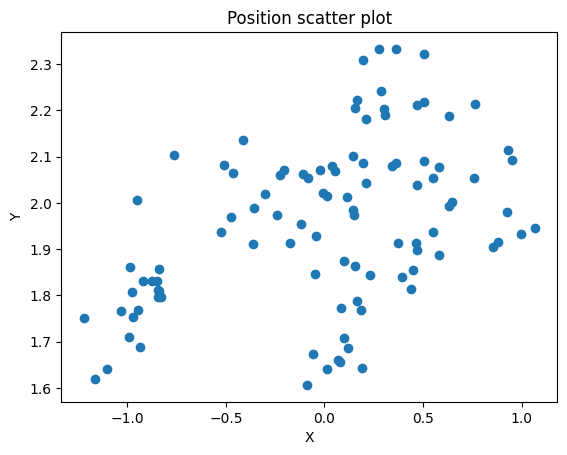

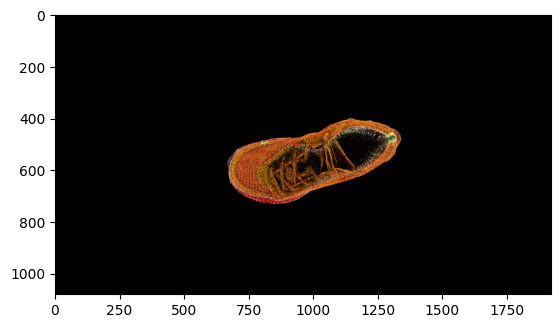

In [33]:
file_path = 'nike.splat'
splats = parse_splats(file_path)

# Define your camera and perspective settings
eye = np.array([0, -10, 10])
target = np.array([0, 0, 0])
up = np.array([0, 1, 0])
fov = 90  # Field of view in degrees
aspect_ratio = 16 / 9  # Screen aspect ratio
near, far = 0.1, 1000  # Near and far planes
image_size = (1920, 1080)  # Image dimensions

# Transformation matrices
# For simplicity, this example assumes you have functions to create these matrices
view_matrix = view_matrix(eye, target, up)
perspective_matrix = perspective_matrix(fov, aspect_ratio, near, far)

# Transform and render
image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)  # Create a blank image

for splat in splats:
    pos = np.append(splat['position'], 1)  # Convert to homogeneous coordinates
    # Apply transformations
    pos_view = np.dot(view_matrix, pos)  # World to View Space
    pos_clip = np.dot(perspective_matrix, pos_view)  # View to Clip Space
    pos_ndc = pos_clip[:3] / pos_clip[3]  # Perspective divide to NDC
    # Convert NDC to screen coordinates
    x = int((pos_ndc[0] + 1) * 0.5 * image_size[0])
    y = int((1 - pos_ndc[1]) * 0.5 * image_size[1])  # Flip y-axis
    if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
        image[y, x, :] = splat['color'][:3]  # Draw pixel (ignoring alpha)

plt.imshow(image)
plt.show()
